### Imports

In [22]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from math import sqrt
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.metrics import confusion_matrix, matthews_corrcoef, plot_roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statistics import mean

# Question 1. 

**For this question, you only need to do programming for Part 1.1 - 1.6. You will only be asked to provide answers in Part 1.7.**

# Part 1.0. Data Prep

### 1. Data Exploration

In [23]:
PATH_TO_Q1_DATA = 'data/HW3_Q1_DATA.csv'
df_original = pd.read_csv(PATH_TO_Q1_DATA)
print(df_original.shape)
df_original.head()

(121913, 19)


,Sex,Intubated,Pneumonia,Age,Pregnant,Diabetes,COPD,Asthma,Immunocompromised,Hypertension,Other_Disease,Cardiovascular_disease,Obesity,Renal_disease,Smoker,Exposure_to_others_with_COVID,Has_COVID,ICU,Died
0,F,N,N,54,N,N,N,N,N,N,N,N,Y,N,N,NaN,Y,N,N
1,M,N,Y,30,NaN,N,N,N,N,N,N,N,N,N,N,NaN,Y,N,N
2,F,N,N,60,N,Y,N,N,N,Y,N,Y,N,N,N,NaN,Y,N,Y
3,M,N,Y,47,NaN,Y,N,N,N,N,N,N,N,N,N,NaN,Y,Y,Y
4,M,N,N,63,NaN,N,N,N,N,Y,N,N,N,N,N,NaN,Y,N,N


In [24]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121913 entries, 0 to 121912
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Sex                            121913 non-null  object
 1   Intubated                      121789 non-null  object
 2   Pneumonia                      121912 non-null  object
 3   Age                            121913 non-null  int64 
 4   Pregnant                       48676 non-null   object
 5   Diabetes                       121244 non-null  object
 6   COPD                           121329 non-null  object
 7   Asthma                         121328 non-null  object
 8   Immunocompromised              121233 non-null  object
 9   Hypertension                   121304 non-null  object
 10  Other_Disease                  120872 non-null  object
 11  Cardiovascular_disease         121267 non-null  object
 12  Obesity                        121279 non-nu

In [25]:
df_original['Died'].value_counts()

N    89357
Y    32556
Name: Died, dtype: int64

### 1. Encode data

In [26]:
# convert categorical data to numerical values
# drop one of each of the binary categories because it is not necessary (all info is encoded by one column)
df_encoded=pd.get_dummies(df_original, drop_first=True,dummy_na=True)
print(df_encoded.shape)
df_encoded.head()

(121913, 38)


,Age,Sex_M,Sex_nan,Intubated_Y,Intubated_nan,Pneumonia_Y,Pneumonia_nan,Pregnant_Y,Pregnant_nan,Diabetes_Y,...,Smoker_nan,Exposure_to_others_with_COVID_Y,Exposure_to_others_with_COVID_nan,Has_COVID_Pending,Has_COVID_Y,Has_COVID_nan,ICU_Y,ICU_nan,Died_Y,Died_nan
0,54,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,30,1,0,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,60,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
3,47,1,0,0,0,1,0,0,1,1,...,0,0,1,0,1,0,1,0,1,0
4,63,1,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0


In [27]:
df_encoded.drop('Age',axis='columns').sum(axis='rows')

Sex_M                                73071
Sex_nan                                  0
Intubated_Y                           9965
Intubated_nan                          124
Pneumonia_Y                          73747
Pneumonia_nan                            1
Pregnant_Y                            1071
Pregnant_nan                         73237
Diabetes_Y                           35481
Diabetes_nan                           669
COPD_Y                                5493
COPD_nan                               584
Asthma_Y                              3144
Asthma_nan                             585
Immunocompromised_Y                   4726
Immunocompromised_nan                  680
Hypertension_Y                       40344
Hypertension_nan                       609
Other_Disease_Y                       7287
Other_Disease_nan                     1041
Cardiovascular_disease_Y              6305
Cardiovascular_disease_nan             646
Obesity_Y                            25127
Obesity_nan

### 1. Visualize Data

In [28]:
# plot data so I can see what shape it takes
y = df_encoded['Died_Y']
print(y.shape)
X = df_encoded.drop('Died_Y',axis='columns')
print(X.shape)

(121913,)
(121913, 37)


<AxesSubplot:xlabel='pca1', ylabel='pca2'>

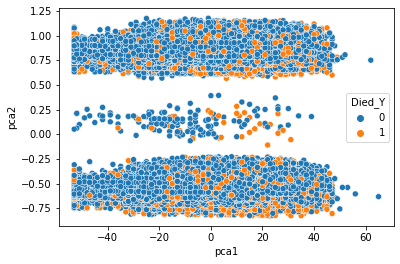

In [29]:
# use PCA to visualize data
pca = PCA(n_components=2).fit_transform(df_encoded.drop('Died_Y',axis='columns')) 
df_pca_plot = pd.DataFrame(pca, columns=['pca1','pca2'])
df_pca_plot_concat = df_pca_plot.assign(Died_Y=y.values)
sns.scatterplot(x='pca1', y='pca2', data=df_pca_plot_concat, legend='full',hue='Died_Y')

## 1. Define Functions and Data Structure

### 1. Define Functions for Capturing Classifier Metrics
Metrics to capture:
- Accuracy
- Sensitivity & Specificity
- The positive and negative predictive values 
- F1-score
- The Matthews Correlation Coefficient
- AUC (Area under the ROC curve)

In [30]:
def get_confusion_matrix(clf,X,y):
    '''
    Calculates the confusion matrix for a given X,y and classifier.
    
    Args:
        clf: classifier
        X: features
        y: labels
    
    Returns:
        confusion matrix for classifier
    '''
    y_predict = clf.predict(X)
    y_true = y
   
    # confusion matrix
    return confusion_matrix(y_true, y_predict)

In [31]:
def y_score_from_decision_function(clf,X):
    '''
    Uses decision_function() to calculate y_score because classifier doesn't have predict_prob().
    
    Args:
        clf: classifier
        X: features dataset
    
    Returns:
        Results of decision_function().
    '''
    return clf.decision_function(X)

In [32]:
def y_score_from_predict_proba(clf,X):
    '''
    Uses predict_proba() to calculate y_score.
    
    Args:
        clf: classifier
        X: features dataset
    
    Returns:
        Results of predict_proba().
    '''
    return clf.predict_proba(X)[:,1]

In [33]:
def calc_classifier_metrics(cm, y_true, y_predict, y_score):
    '''
    Calculates metrics based on given label value, prediction, and score.
    
    Args:
        cm: confusion matrix
        y_true: true label
        y_predict: predicted label
        y_score: score for the label
        
    Returns:
        Numpy array with eight metrics:
            (0) Accuracy
            (1) Sensitivity
            (2) Specificity
            (3) positive predictive value
            (4) negative predictive value
            (5) F1-score
            (6) Matthews Correlation Coefficient
            (7) AUC
    '''
    
    tn, fp, fn, tp = cm.ravel()
    
    # accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # sensitivity
    sen = tp / (tp + fn)
    
    # specificity
    spec = tn / (tn + fp)
    
    # precision
    prec = tp / (tp + fp)
    
    # positive predictive value
    ppv = prec
    
    # negative predictive value
    npv = tn / (fn + tn)
    
    # f1 score
    f1 = (2 * tp) / (2 * tp + fp + fn)
    
    # matthew correlation coefficient
    mcc = ((tp * tn) - (fp * fn))/ sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))
#     mcc = matthews_corrcoef(y_true,y_predict)
    
    # area under the receiver (AUC)
    auc = roc_auc_score(y_true, y_score)
    
    # return numpy array  
    return [acc,sen,spec,ppv,npv,f1,mcc,auc]

### 1. Define Functions to Store Metrics

In [34]:
def add_row(df, section, description, metrics):
    '''
    Appends row of metrics to given DataFrame.
    
    Args:
        df: DataFrame with metrics data.
        section: Section of the notebook the data which generated the data
        description: Short description of the type of feature selected used
        metrics: Numpy array of training metrics. Contains eight metrics:
            (0) Accuracy
            (1) Sensitivity
            (2) Specificity
            (3) positive predictive value
            (4) negative predictive value
            (5) F1-score
            (6) Matthews Correlation Coefficient
            (7) AUC
    
    Returns:
        DataFrame with row added for the given X,y and classifier.
    '''
    
    data = [section,description] + metrics 
    new_row = pd.Series(data, index = df.columns)
    return df.append(new_row,ignore_index=True)

In [35]:
def add_metrics_to_table(df, section, description, clf, X, y, y_score):
    '''
    Calculates metrics for given X,y using given classifier and adds result to given DataFrame.
    
    Args:
        df: DataFrame with metrics data.
        section: Section of the notebook the data which generated the data
        description: Short description of the type of feature selected used
        clf: classifier
        X: features dataset
        y: labels
        y_score: score for the current set of labels
    
    Returns:
        DataFrame with row added for the given X,y and classifier.
    '''
    
    # for validation purposes
    print(clf.score(X,y),'\n')
    
    # calculate confusion matrix
    cm = get_confusion_matrix(clf,X,y)
    
    # calculate metrics
    y_predict = clf.predict(X)
    metrics = calc_classifier_metrics(cm,y,y_predict,y_score)
    
    # add row to results DataFrame
    return add_row(df, section, description, metrics)

### 1. Define Data Structure
DataFrame to store classifier metric results for all tests

In [36]:
# dataframe to collect results of all tests
df_results = pd.DataFrame(
    columns=['Section',
             'Description',
             'Accuracy',
             'Sensitivity',
             'Specificity',
             'Pos_Predictive_Val',
             'Neg_Predictive_Val',
             'F1_Score',
             'Matthew_Corr_Coef',
             'AUC'
            ]).astype(
    dtype= {'Section':'int64',
            'Description':'object',
            'Accuracy':'float64',
            'Sensitivity':'float64',
             'Specificity':'float64',
             'Pos_Predictive_Val':'float64',
             'Neg_Predictive_Val':'float64',
             'F1_Score':'float64',
             'Matthew_Corr_Coef':'float64',
             'AUC':'float64'
           })

df_results.head()

,Section,Description,Accuracy,Sensitivity,Specificity,Pos_Predictive_Val,Neg_Predictive_Val,F1_Score,Matthew_Corr_Coef,AUC


# Part 1.1 Select features and train classifiers

## Part 1.1 Work 

**TODO:**
- **Step 1: Select and apply a filter-based or wrapper-based feature selection method to the data.**
- **Step 2: Train a classifier using the selected features. Use 10-fold cross validation.**

**Tips:**

1. **You may find the filter-based or wrapper-based methods you used in HW2 useful.**
2. **Scikit-learn implement many classifiers, see the comparisons of their performance and introductions [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).**
3. **Scikit-learn also implement classifiers with built-in cross validations, [for example](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html)**

### 1.1. Define functions

In [37]:
def run_crossfold_recursive_feature_elimination(X,y):
    '''
    Trains Decision Tree Classifier using RFE and 10-fold cross validation.
    
    Args:
        X: features data
        y: labels
    
    Returns:
        Trained model
    '''
    clf = DecisionTreeClassifier()
    rfecv = RFECV(estimator=clf, step=1, cv=10,scoring='neg_mean_squared_error',n_jobs=3)
    return rfecv.fit(X, y)


In [38]:
def get_feature_list(X, support):
    '''
    Generates list of features.
    
    Args:
        X: features data
        support: Numpy array of selected features generated by RFE. 
                 Features are ordered similar to the dataset. Array 
                 uses value True to indicate feature was selected, False otherwise.
    
    Returns:
        List of features
    '''
    features = []
    for i,val in enumerate(support):
        if val:
            features.append(X.columns[i])      
    return features

In [39]:
def build_X_from_features(X, features):
    '''
    Selects subset of feature data for given features.
    
    Args:
        X: features data
        features: List of features to include in dataset
    
    Returns:
        Dataset containing the chosen features
    '''
    return X.loc[:][features]

In [40]:
def train_random_forest_classifier(X,y):
    '''
    Trains a Random Forest Classifier.
    
    Args:
        X: features data
        y: labels
    
    Returns:
        Trained model
    '''
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    return clf.fit(X,y)
      

In [41]:
def run_classifier_with_cross_validation_1_1(X,y,k):
    '''
    Trains a Random Forest Classifier using k-fold cross validation.
    
    Args:
        X: features data
        y: labels
        k: number of folds for cross validation
    
    Returns:
        Score average
    '''
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    scores = cross_val_score(clf, X, y, cv=k)
    return scores.mean()  

### 1.1. Perform Feature Selection

In [42]:
# select data
X_1_1 = df_encoded.drop(['Died_Y','Died_nan'],axis='columns')
y_1_1 = df_encoded.loc[:]['Died_Y']
print(X_1_1.shape)
print(y_1_1.shape)

(121913, 36)
(121913,)


In [43]:
%%time

# select features
rfe_1_1 = run_crossfold_recursive_feature_elimination(X_1_1,y_1_1)
features_1_1 = get_feature_list(X_1_1,rfe_1_1.support_)

CPU times: user 8.1 s, sys: 234 ms, total: 8.33 s
Wall time: 46.6 s


In [22]:
features_1_1

['Age',
 'Intubated_Y',
 'Pneumonia_Y',
 'Exposure_to_others_with_COVID_nan',
 'Has_COVID_Y']

### 1.1. Score Classifier using selected features

In [23]:
%%time

# limit features to those selected by previous step
X_1_1_select = build_X_from_features(X_1_1,features_1_1)
print(X_1_1_select.shape)

# score classifier using 10-fold cross validation
score = run_classifier_with_cross_validation_1_1(X_1_1_select,y_1_1,10)
print("Accuracy:",score)

(121913, 5)
Accuracy: 0.7482713242213663
CPU times: user 14.5 s, sys: 153 ms, total: 14.6 s
Wall time: 14.7 s


In [24]:
%%time

# run classifier on full dataset to capture metrics
clf_1_1 = train_random_forest_classifier(X_1_1_select,y_1_1)

CPU times: user 1.51 s, sys: 12.6 ms, total: 1.52 s
Wall time: 1.52 s


In [25]:
# capture metrics for later use
y_score_1_1 = y_score_from_predict_proba(clf_1_1,X_1_1_select)
df_results = add_metrics_to_table(df_results,1,"Wrapper",clf_1_1,X_1_1_select,y_1_1,y_score_1_1)
df_results

0.7482220928038847 



,Section,Description,Accuracy,Sensitivity,Specificity,Pos_Predictive_Val,Neg_Predictive_Val,F1_Score,Matthew_Corr_Coef,AUC
0,1,Wrapper,0.748222,0.090367,0.987902,0.731295,0.7488,0.160857,0.193848,0.755638


# Part 1.2. Work

**TODO:** 
- **Step 1: Select a learning algorithm that performs embedded feature selection.** 
- **Step 2: Train a classifier using the selected features. Use 10-fold cross validation.**

**Tip:** 
1. **Scikit-learn implement many classifiers, see the comparisons of their performance and introductions [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).**
  

2. **Scikit-learn also implement classifiers with built-in cross validations, [for example](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html).**

### 1.2. Define Functions

In [ ]:
def run_embedded_feature_selection(X,y):
    '''
    Trains 
    '''
    
    # split data
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
    
    # select features
    sel = SelectFromModel(RandomForestClassifier())
    return sel.fit(X_train, y_train)

In [ ]:
def run_classifier_with_cross_validation_1_2(X,y,k):
    clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],cv=k).fit(X, y)
    return clf.score(X, y)

In [27]:
def train_ridge_classifier(X,y):
    clf = RidgeClassifier().fit(X, y)
    return clf.fit(X,y)

#### Feature Selection

In [28]:
# select data
X_1_2 = df_encoded.drop(['Died_Y','Died_nan'],axis='columns')
y_1_2 = df_encoded.loc[:]['Died_Y']
print(X_1_2.shape)
print(y_1_2.shape)

(121913, 36)
(121913,)


In [29]:
%%time

# select features
embedded_1_2 = run_embedded_feature_selection(X_1_2,y_1_2)
features_1_2 = get_feature_list(X_1_2,embedded_1_2.get_support())

CPU times: user 7.54 s, sys: 113 ms, total: 7.65 s
Wall time: 7.67 s


In [30]:
features_1_2

['Age',
 'Intubated_Y',
 'Pneumonia_Y',
 'Obesity_Y',
 'Exposure_to_others_with_COVID_nan',
 'Has_COVID_Y']

#### Classifier

In [31]:
%%time

# limit features to those selected by previous step
X_1_2_select = build_X_from_features(X_1_2,features_1_2)
print(X_1_2_select.shape)

# score classifier using 10-fold cross validation
score = run_classifier_with_cross_validation_1_2(X_1_2_select,y_1_2,10)
print("Accuracy:",score)

(121913, 6)
Accuracy: 0.7648405010130175
CPU times: user 4.51 s, sys: 145 ms, total: 4.65 s
Wall time: 1.22 s


In [32]:
%%time

# run classifier on full dataset to capture metrics
clf_1_2 = train_ridge_classifier(X_1_2_select,y_1_2)

CPU times: user 220 ms, sys: 8.92 ms, total: 228 ms
Wall time: 57.1 ms


In [33]:
# capture metrics for later use
y_score_1_2 = y_score_from_decision_function(clf_1_2,X_1_2_select)
df_results = add_metrics_to_table(df_results,2,"Embedded",clf_1_2,X_1_2_select,y_1_2,y_score_1_2)
df_results

0.7648405010130175 



,Section,Description,Accuracy,Sensitivity,Specificity,Pos_Predictive_Val,Neg_Predictive_Val,F1_Score,Matthew_Corr_Coef,AUC
0,1,Wrapper,0.748222,0.090367,0.987902,0.731295,0.7488,0.160857,0.193848,0.755638
1,2,Embedded,0.764841,0.236792,0.957228,0.668546,0.7749,0.349718,0.293321,0.774016


### Part 1.3 Work 

In [34]:
# TODO: 
#   Step 1: Select and apply a data imputation method to handle the missing data.
#   Step 2: Apply the  wrapper based feature selection method you used in part 1.1.
#   Step 3: Train a classifier using the selected features. Use the same classifier you used in part 1.1. Use 10-fold cross validation.

# Tip: 
#   1. Sciki-learn implements different imputation methods. Take a look at https://scikit-learn.org/stable/modules/impute.html
#   and use the one you think most appropriate.

#### Define Functions

In [35]:



def impute_data(df):
    imp = SimpleImputer(strategy="most_frequent")
    
    # impute missing values
    ndarray_imputed = imp.fit_transform(df)
    print(ndarray_imputed.shape)
    
    # convert back to DataFrame
    df_imputed = pd.DataFrame(ndarray_imputed, columns=df.columns) 
    
    # convert Age to int64 data type so get_dummies() doesn't treat it as a category
    df_imputed = df_imputed.astype({'Age': 'int64'})
    
    return df_imputed  

#### Impute missing values and encode data

In [36]:
df_imputed = impute_data(df_original)
df_imputed

(121913, 19)


,Sex,Intubated,Pneumonia,Age,Pregnant,Diabetes,COPD,Asthma,Immunocompromised,Hypertension,Other_Disease,Cardiovascular_disease,Obesity,Renal_disease,Smoker,Exposure_to_others_with_COVID,Has_COVID,ICU,Died
0,F,N,N,54,N,N,N,N,N,N,N,N,Y,N,N,N,Y,N,N
1,M,N,Y,30,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N
2,F,N,N,60,N,Y,N,N,N,Y,N,Y,N,N,N,N,Y,N,Y
3,M,N,Y,47,N,Y,N,N,N,N,N,N,N,N,N,N,Y,Y,Y
4,M,N,N,63,N,N,N,N,N,Y,N,N,N,N,N,N,Y,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121908,M,N,Y,45,N,N,N,N,N,N,N,N,N,N,N,N,Pending,N,N
121909,M,Y,Y,68,N,N,N,N,N,Y,N,N,Y,N,N,N,Pending,Y,N
121910,M,Y,Y,48,N,Y,N,N,N,Y,N,N,N,N,N,N,Pending,Y,Y
121911,F,N,Y,31,N,N,N,N,N,N,N,N,N,N,N,N,Pending,N,N


In [37]:
df_imputed_encoded=pd.get_dummies(df_imputed, drop_first=True)
df_imputed_encoded

,Age,Sex_M,Intubated_Y,Pneumonia_Y,Pregnant_Y,Diabetes_Y,COPD_Y,Asthma_Y,Immunocompromised_Y,Hypertension_Y,Other_Disease_Y,Cardiovascular_disease_Y,Obesity_Y,Renal_disease_Y,Smoker_Y,Exposure_to_others_with_COVID_Y,Has_COVID_Pending,Has_COVID_Y,ICU_Y,Died_Y
0,54,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,30,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,60,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1
3,47,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1
4,63,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121908,45,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
121909,68,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
121910,48,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1
121911,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#### Feature Selection

In [38]:
# select data
X_1_3 = df_imputed_encoded.drop('Died_Y',axis='columns')
y_1_3 = df_imputed_encoded.loc[:]['Died_Y']
print(X_1_3.shape)
print(y_1_3.shape)

(121913, 19)
(121913,)


In [39]:
%%time

# select features
rfe_1_3 = run_crossfold_recursive_feature_elimination(X_1_3,y_1_3)
features_1_3 = get_feature_list(X_1_3,rfe_1_3.support_)

CPU times: user 2.27 s, sys: 60.3 ms, total: 2.33 s
Wall time: 12.3 s


In [40]:
features_1_3

['Age', 'Intubated_Y', 'Pneumonia_Y', 'Has_COVID_Y']

#### Classifier

In [41]:
%%time

# limit features to those selected by previous step
X_1_3_select = build_X_from_features(X_1_3,features_1_3)
print(X_1_3_select.shape)

# score classifier using 10-fold cross validation
score = run_classifier_with_cross_validation_1_1(X_1_3_select,y_1_3,10)
print("Accuracy:",score)

(121913, 4)
Accuracy: 0.74764795454932
CPU times: user 14.5 s, sys: 116 ms, total: 14.6 s
Wall time: 14.6 s


In [42]:
%%time

# run classifier on full dataset to capture metrics
clf_1_3 = train_random_forest_classifier(X_1_3_select,y_1_3)

CPU times: user 1.55 s, sys: 12.2 ms, total: 1.56 s
Wall time: 1.56 s


In [43]:
# capture metrics for later use
y_score_1_3 = y_score_from_predict_proba(clf_1_3,X_1_3_select)
df_results = add_metrics_to_table(df_results,3,"Wrapper imputed",clf_1_3,X_1_3_select,y_1_3,y_score_1_3)
df_results

0.7470163149130937 



,Section,Description,Accuracy,Sensitivity,Specificity,Pos_Predictive_Val,Neg_Predictive_Val,F1_Score,Matthew_Corr_Coef,AUC
0,1,Wrapper,0.748222,0.090367,0.987902,0.731295,0.748800,0.160857,0.193848,0.755638
1,2,Embedded,0.764841,0.236792,0.957228,0.668546,0.774900,0.349718,0.293321,0.774016
2,3,Wrapper imputed,0.747016,0.086251,0.987757,0.719631,0.747922,0.154040,0.186018,0.737923


### Part 1.4 Work 

In [44]:
# TODO: 
#   Step 1: Apply a data imputation method to eliminate any missing values in the data. Use the same method you used in part 1.3. 
#   Step 2: Train a classifier. Use the same classifier you used in part 1.2. Use 10-fold cross validation.

#### Feature Selection

In [45]:
# use the same imputed data from 1.3
X_1_4 = X_1_3
y_1_4 = y_1_3
print(X_1_4.shape)
print(y_1_4.shape)

(121913, 19)
(121913,)


In [46]:
%%time

# select features
embedded_1_4 = run_embedded_feature_selection(X_1_4,y_1_4)
features_1_4 = get_feature_list(X_1_4,embedded_1_4.get_support())

CPU times: user 5.51 s, sys: 86.7 ms, total: 5.6 s
Wall time: 5.6 s


In [47]:
features_1_4

['Age', 'Intubated_Y', 'Has_COVID_Y']

#### Classifier

In [48]:
%%time

# limit features to those selected by previous step
X_1_4_select = build_X_from_features(X_1_4,features_1_4)
print(X_1_4_select.shape)

# score classifier using 10-fold cross validation
score = run_classifier_with_cross_validation_1_2(X_1_4_select,y_1_4,10)
print("Accuracy:",score)

(121913, 3)
Accuracy: 0.752446416706996
CPU times: user 3.8 s, sys: 81 ms, total: 3.88 s
Wall time: 1.02 s


In [49]:
%%time

# run classifier on full dataset to capture metrics
clf_1_4 = train_ridge_classifier(X_1_4_select,y_1_4)

CPU times: user 182 ms, sys: 5.26 ms, total: 187 ms
Wall time: 46.4 ms


In [50]:
# capture metrics for later use
y_score_1_4 = y_score_from_decision_function(clf_1_4,X_1_4_select)
df_results = add_metrics_to_table(df_results,4,"Embedded Imputed",clf_1_4,X_1_4_select,y_1_4,y_score_1_4)
df_results

0.752446416706996 



,Section,Description,Accuracy,Sensitivity,Specificity,Pos_Predictive_Val,Neg_Predictive_Val,F1_Score,Matthew_Corr_Coef,AUC
0,1,Wrapper,0.748222,0.090367,0.987902,0.731295,0.748800,0.160857,0.193848,0.755638
1,2,Embedded,0.764841,0.236792,0.957228,0.668546,0.774900,0.349718,0.293321,0.774016
2,3,Wrapper imputed,0.747016,0.086251,0.987757,0.719631,0.747922,0.154040,0.186018,0.737923
3,4,Embedded Imputed,0.752446,0.158527,0.968833,0.649509,0.759623,0.254852,0.228270,0.740902


### Part 1.5 Work 

In [51]:
# TODO: 
#   Step 1: Apply a data imputation method to eliminate any missing values in the data. Use the same method you used in parts 1.3 & 1.4. 
#   Step 2: Select a learning algorithm that performs cost-sensitive learning. 
#   Step 3: Adjust the costs until you find a classifier that maximizes the F1-score, subject to the constraint that it achieves 95% sensitivity for the label ‘Y’.  Use 10-fold cross validation.

# Tip: 
#   1. F1-score: https://en.wikipedia.org/wiki/F1_score
#   2. Scikit-learn supports extending the classifiers to cost-sensitive learning.
#   Take a look at this tutorial: https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/

#### Define Functions

In [52]:
def calc_sensitivity_and_f1(cm):
    
    tn, fp, fn, tp = cm.ravel()
    
    # sensitivity
    sen = tp / (tp + fn)
    
    # specificity
    spec = tn / (tn + fp)
    
    # precision
    prec = tn / (tn + fp)
    
    # f1 score
    f1 = 2 * (prec * sen) / (prec + sen) 
    
    return (sen,f1)


def train_cost_sensitive_classifier(X,y,k,weights):
    clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],cv=k, class_weight=weights)
    return clf.fit(X, y)

In [53]:
def run_balanced_case(X,y):
    
    # train model
    clf = train_cost_sensitive_classifier(X,y,10,'balanced')

    # calculate metrics
    cm = get_confusion_matrix(clf,X,y)
    sen,f1=calc_sensitivity_and_f1(cm)
    
    print('Sensitivity:',sen)
    print('F-score:',f1)
    return 


def find_zero_weight_to_maximize_f1(X,y):
    
    max_f1=0.0
    zero_weight_for_max=0.0
    
    # check all weight combinations
    zero_weight=0.0
    while zero_weight < 0.2:
        zero_weight = round(zero_weight + 0.005,3)
        one_weight = round(1 - zero_weight,3)
        print(".",end = '')
        
        # train model
        clf = train_cost_sensitive_classifier(X,y,10,{0:zero_weight, 1:one_weight})
        
        # calculate metrics
        cm = get_confusion_matrix(clf,X,y)
        sen,f1 = calc_sensitivity_and_f1(cm)
        if sen >= 0.95 and f1 > max_f1:
            max_f1 = f1
            zero_weight_for_max=zero_weight
            
    print('\nmax_f1:',max_f1)
    print('zero_weight for max_f1:',zero_weight_for_max)
    return zero_weight_for_max

#### Data Selection

In [54]:
# use the same imputed data as in 1.3
X_1_5 = X_1_3
y_1_5 = y_1_3
print(X_1_5.shape)
print(y_1_5.shape)

# check label counts to see imbalance
y_1_5.value_counts()

(121913, 19)
(121913,)


0    89357
1    32556
Name: Died_Y, dtype: int64

#### Feature Selection

In [55]:
%%time

# select features
embedded_1_5 = run_embedded_feature_selection(X_1_5,y_1_5)
features_1_5 = get_feature_list(X_1_5,embedded_1_5.get_support())

CPU times: user 5.9 s, sys: 88 ms, total: 5.99 s
Wall time: 5.59 s


In [56]:
features_1_5

['Age', 'Intubated_Y', 'Has_COVID_Y']

#### Find Weights

In [57]:
%%time

# limit features to those selected by previous step
X_1_5_select = build_X_from_features(X_1_5,features_1_5)
print(X_1_5_select.shape,'\n')

# check built-in setting
print("Built-in Setting")
run_balanced_case(X_1_5_select,y_1_5)

# find optimal weights given the constraints
print("\nOptimal Weights")
best_zero = find_zero_weight_to_maximize_f1(X_1_5_select,y_1_5)
best_one = round(1-best_zero,3)
print("0 weight:",best_zero)
print("1 weight:",best_one)

(121913, 3) 

Built-in Setting
Sensitivity: 0.7040484088954417
F-score: 0.6752668419617864

Optimal Weights
........................................
max_f1: 0.37042679886783925
zero_weight for max_f1: 0.12
0 weight: 0.12
1 weight: 0.88
CPU times: user 3min 4s, sys: 3.77 s, total: 3min 8s
Wall time: 47.5 s


In [58]:
%%time

# run classifier using best weights
weights = {0:best_zero, 1:best_one}
clf_1_5 = train_cost_sensitive_classifier(X_1_5_select,y_1_5,10,weights)

CPU times: user 4.27 s, sys: 86.9 ms, total: 4.35 s
Wall time: 1.09 s


In [59]:
# capture metrics for later use
y_score_1_5 = y_score_from_decision_function(clf_1_5,X_1_5_select)
df_results = add_metrics_to_table(df_results,5,"Cost Sensitive",clf_1_5,X_1_5_select,y_1_5,y_score_1_5)
df_results

0.42362176306054317 



,Section,Description,Accuracy,Sensitivity,Specificity,Pos_Predictive_Val,Neg_Predictive_Val,F1_Score,Matthew_Corr_Coef,AUC
0,1,Wrapper,0.748222,0.090367,0.987902,0.731295,0.748800,0.160857,0.193848,0.755638
1,2,Embedded,0.764841,0.236792,0.957228,0.668546,0.774900,0.349718,0.293321,0.774016
2,3,Wrapper imputed,0.747016,0.086251,0.987757,0.719631,0.747922,0.154040,0.186018,0.737923
3,4,Embedded Imputed,0.752446,0.158527,0.968833,0.649509,0.759623,0.254852,0.228270,0.740902
4,5,Cost Sensitive,0.423622,0.955799,0.229730,0.311338,0.934493,0.469683,0.213562,0.739314


### Part 1.6 Work 

In [60]:
# TODO: 
#   Step 1: Implement a function calculating the weighted average F1-score, following 
#       the steps in the homework problem statement.
#   Step 2: Find a classifier that achieves a weighted average F1-score of at least 0.74 using 10-fold cross validation.

# Tip: 
#   1. F1-score: https://en.wikipedia.org/wiki/F1_score
#   2. Scikit-learn supports extending the classifiers to cost-sensitive learning.
#   Take a look at this tutorial: https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/



#### Define Functions

Reference:  https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

##### Defining TP, FP, FN, TN when switching which label is true positive.

Example:

True Class|Predicted Class
---|---
Y|Y
Y|Y
Y|N
Y|N
Y|Y
N|N
N|Y
N|N
N|N
N|N

##### Setting Y as positive class, N as negative class


.|.
---|---
TP=3|FP=1
FN=2|TN=4

##### Setting X as positive class, Y as negative class

.|.
---|---
TP=4|FP=2
FN=1|TN=3

To switch between the two:
- TP -> TN
- TN -> TP
- FN -> FP
- FP -> FN

In [61]:
def weighted_f1(cm):
    '''
    Calculates a weighted F1-score using given confusion matrix cm. 
    '''
    
    tn, fp, fn, tp = cm.ravel()
    
    # F1 score computed using label 'Y' as true positive
    F_1_Y = (2 * tp) / (2 * tp + fp + fn)
    
    # F1 score computed using label 'N' as true negative
    F_1_N = (2 * tn) / (2 * tn + fp + fn)
    
    # number of instances with label 'Y'
    n_Y = tp + fp
    
    # number of instances with label 'N'
    n_N = tn + fn
    
    
    # calculate weights
    a = n_Y / (n_Y + n_N)
    
    b = n_N / (n_Y + n_N)
    
    
    # calculated weighted f1
    f1_weighted = (a * F_1_Y) + (b * F_1_N)
    
    return f1_weighted

In [62]:


def run_comparison_test(X,y):

    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=42)
    
    # run against common classifiers
    classifiers = [
        KNeighborsClassifier(3),
#         SVC(kernel="linear", C=0.025),
#         SVC(gamma=2, C=1),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB()]

    for i, clf in enumerate(classifiers):
        
        # train model
        clf.fit(X_train, y_train)

        # calculate metric
        cm = get_confusion_matrix(clf,X_test,y_test)
        print(i,"Weighted F1:",weighted_f1(cm))

#### Test 1 - baseline with imputed data

In [63]:
%%time

# data
X_1_6 = X_1_3
y_1_6 = y_1_3
print(X_1_6.shape)
print(y_1_6.shape)

# select features
rfe_1_6 = run_crossfold_recursive_feature_elimination(X_1_6,y_1_6)
features_1_6 = get_feature_list(X_1_6,rfe_1_6.support_)
print(features_1_6)

# comparison
run_comparison_test(X_1_6,y_1_6)

(121913, 19)
(121913,)
['Age', 'Intubated_Y', 'Pneumonia_Y', 'Has_COVID_Y']
0 Weighted F1: 0.7232829155090345
1 Weighted F1: 0.8196909314890874
2 Weighted F1: 0.8436842336147228
3 Weighted F1: 0.7881005419223773
4 Weighted F1: 0.7952469007814592
5 Weighted F1: 0.6508015652982706
CPU times: user 1min 2s, sys: 486 ms, total: 1min 2s
Wall time: 34.8 s


#### Test 2 - undersampling imputed data

In [64]:
%%time



# undersample the data
rus = RandomUnderSampler(random_state=0)

X_1_6, y_1_6 = rus.fit_resample(X_1_3, y_1_3)
print(X_1_6.shape)
print(y_1_6.shape)
print(y_1_6.value_counts()) # counts exactly match


# select features
rfe_1_6 = run_crossfold_recursive_feature_elimination(X_1_6,y_1_6)
features_1_6 = get_feature_list(X_1_6,rfe_1_6.support_)
print(features_1_6)


# comparison
run_comparison_test(X_1_6,y_1_6)

(65112, 19)
(65112,)
1    32556
0    32556
Name: Died_Y, dtype: int64
['Age', 'Intubated_Y', 'Pneumonia_Y', 'Exposure_to_others_with_COVID_Y', 'Has_COVID_Y']
0 Weighted F1: 0.6324128741100813
1 Weighted F1: 0.6847637498510057
2 Weighted F1: 0.6798926068612665
3 Weighted F1: 0.6903776476046386
4 Weighted F1: 0.6909961341104789
5 Weighted F1: 0.669416224386138
CPU times: user 30.3 s, sys: 320 ms, total: 30.6 s
Wall time: 16.6 s


#### Test 3 - oversampling imputed data

In [65]:
%%time



ros = RandomOverSampler(random_state=42)
X_1_6, y_1_6 = ros.fit_resample(X_1_3, y_1_3)
print(X_1_6.shape)
print(y_1_6.shape)
print(y_1_6.value_counts()) # counts exactly match


# select features
rfe_1_6 = run_crossfold_recursive_feature_elimination(X_1_6,y_1_6)
features_1_6 = get_feature_list(X_1_6,rfe_1_6.support_)
print(features_1_6)


# comparison
run_comparison_test(X_1_6,y_1_6)

(178714, 19)
(178714,)
1    89357
0    89357
Name: Died_Y, dtype: int64
['Age', 'Sex_M', 'Intubated_Y', 'Pneumonia_Y', 'Diabetes_Y', 'COPD_Y', 'Immunocompromised_Y', 'Hypertension_Y', 'Other_Disease_Y', 'Cardiovascular_disease_Y', 'Obesity_Y', 'Renal_disease_Y', 'Smoker_Y', 'Exposure_to_others_with_COVID_Y', 'Has_COVID_Y', 'ICU_Y']
0 Weighted F1: 0.6824873890613112
1 Weighted F1: 0.681366514106424
2 Weighted F1: 0.6774936329070209
3 Weighted F1: 0.6915949973217448
4 Weighted F1: 0.6952367828463752
5 Weighted F1: 0.6751958145908946
CPU times: user 1min 46s, sys: 1.3 s, total: 1min 47s
Wall time: 1min 4s


#### Run Selected Configuration

In [66]:



def run_classifier_with_cross_validation_1_6(X,y,k):
    
    # define list to store weighted f1 score for each fold
    weighted_f1_scores = list()
    
    # model
    clf = AdaBoostClassifier()

    # run 10 fold cross validation
    kf=KFold(n_splits=k, shuffle=True)
    for fold, (train, test) in enumerate(kf.split(X, y)):

        # get training rows for this fold
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]

        # train classifier
        clf.fit(X_train,y_train)

        # calculate confusion matrix
        cm = get_confusion_matrix(clf, X_test,y_test)

        # calculate weighted-f1
        w_f1 = weighted_f1(cm)
        weighted_f1_scores.append(w_f1)

    return mean(weighted_f1_scores)


def train_adaboost_classifier(X,y):
    clf = AdaBoostClassifier()
    return clf.fit(X,y)

In [67]:
%%time

# select data
X_1_6 = X_1_3
y_1_6 = y_1_3
print(X_1_6.shape)
print(y_1_6.shape)


# select features
rfe_1_6 = run_crossfold_recursive_feature_elimination(X_1_6,y_1_6)
features_1_6 = get_feature_list(X_1_6,rfe_1_6.support_)
print(features_1_6)


# limit features to those selected by previous step
X_1_6_select = build_X_from_features(X_1_6,features_1_6)
print(X_1_6_select.shape)


# score classifier using 10-fold cross validation
weighted_f1_score = run_classifier_with_cross_validation_1_6(X_1_6_select,y_1_6,10)
print("Weighted F1-Score:",weighted_f1_score)

(121913, 19)
(121913,)
['Age', 'Intubated_Y', 'Pneumonia_Y', 'Has_COVID_Y']
(121913, 4)
Weighted F1-Score: 0.8041213101835569
CPU times: user 15.5 s, sys: 184 ms, total: 15.7 s
Wall time: 27 s


In [68]:
%%time

# run classifier on full dataset to capture metrics
clf_1_6 = train_adaboost_classifier(X_1_6_select,y_1_6)

CPU times: user 1.38 s, sys: 11.5 ms, total: 1.39 s
Wall time: 1.39 s


In [69]:
# capture metrics for later use
y_score_1_6 = y_score_from_decision_function(clf_1_6,X_1_6_select)
df_results = add_metrics_to_table(df_results,6,"Weighted F1 Model",clf_1_6,X_1_6_select,y_1_6,y_score_1_6)
df_results

0.7584424958782082 



,Section,Description,Accuracy,Sensitivity,Specificity,Pos_Predictive_Val,Neg_Predictive_Val,F1_Score,Matthew_Corr_Coef,AUC
0,1,Wrapper,0.748222,0.090367,0.987902,0.731295,0.748800,0.160857,0.193848,0.755638
1,2,Embedded,0.764841,0.236792,0.957228,0.668546,0.774900,0.349718,0.293321,0.774016
2,3,Wrapper imputed,0.747016,0.086251,0.987757,0.719631,0.747922,0.154040,0.186018,0.737923
3,4,Embedded Imputed,0.752446,0.158527,0.968833,0.649509,0.759623,0.254852,0.228270,0.740902
4,5,Cost Sensitive,0.423622,0.955799,0.229730,0.311338,0.934493,0.469683,0.213562,0.739314
5,6,Weighted F1 Model,0.758442,0.220635,0.954385,0.637979,0.770700,0.327879,0.267445,0.750487


### Part 1.7 Work

In [70]:
# Tip:
#   1. Scikit-learn implements different evaluation metrics for classifications,
#   see: https://scikit-learn.org/stable/modules/model_evaluation.html

### Part 1.7 Answers

1. Create a ROC plot with the results from parts 1.1 to 1.6. 
2. Create a table with the following performance metrics for the results from parts 1.1 to 1.6:
    * Accuracy
    * Sensitivity & Specificity
    * The positive and negative predictive values
    * F1-score
    * The Matthews Correlation Coefficient
    * AUC (Area under the ROC curve)

#### ROC Plot

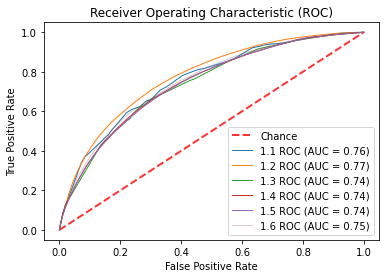

In [71]:


fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],title="Receiver Operating Characteristic (ROC)")
ax.legend(loc="lower right")

# plot all results on one graph

# 1.1 wrapper method
plot_roc_curve(clf_1_1, X_1_1_select, y_1_1,name='1.1 ROC',lw=1, ax=ax)

# 1.2 embedded method
plot_roc_curve(clf_1_2, X_1_2_select, y_1_2,name='1.2 ROC',lw=1, ax=ax)

# 1.3 wrapper method + imputed data
plot_roc_curve(clf_1_3, X_1_3_select, y_1_3,name='1.3 ROC',lw=1, ax=ax)

# 1.4 embedded method + imputed data
plot_roc_curve(clf_1_4, X_1_4_select, y_1_4,name='1.4 ROC',lw=1, ax=ax)

# 1.5 cost-sensitive
plot_roc_curve(clf_1_5, X_1_5_select, y_1_5,name='1.5 ROC',lw=1, ax=ax)

# 1.6 weighted average
plot_roc_curve(clf_1_6, X_1_6_select, y_1_6,name='1.6 ROC',alpha=0.3, lw=1, ax=ax)

plt.show()

#### Performance Metric Table

In [72]:
df_results

,Section,Description,Accuracy,Sensitivity,Specificity,Pos_Predictive_Val,Neg_Predictive_Val,F1_Score,Matthew_Corr_Coef,AUC
0,1,Wrapper,0.748222,0.090367,0.987902,0.731295,0.748800,0.160857,0.193848,0.755638
1,2,Embedded,0.764841,0.236792,0.957228,0.668546,0.774900,0.349718,0.293321,0.774016
2,3,Wrapper imputed,0.747016,0.086251,0.987757,0.719631,0.747922,0.154040,0.186018,0.737923
3,4,Embedded Imputed,0.752446,0.158527,0.968833,0.649509,0.759623,0.254852,0.228270,0.740902
4,5,Cost Sensitive,0.423622,0.955799,0.229730,0.311338,0.934493,0.469683,0.213562,0.739314
5,6,Weighted F1 Model,0.758442,0.220635,0.954385,0.637979,0.770700,0.327879,0.267445,0.750487
